# JaX Flax --> ONNX

This notebook converts brax MLP networks to an ONNX checkpoint.

In [1]:
import os
os.environ["MUJOCO_GL"] = "egl"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
print(os.getcwd())

/home/mohamedash/mujoco_playground/mujoco_playground/experimental


In [2]:
from brax.training.agents.ppo import networks as ppo_networks
from mujoco_playground.config import locomotion_params, manipulation_params
from mujoco_playground import locomotion, manipulation
import functools
import pickle
import jax.numpy as jp
import jax
import tf2onnx
import tensorflow as tf
from tensorflow.keras import layers
import onnxruntime as rt
from brax.training.acme import running_statistics
from brax.training.agents.ppo import checkpoint
import sys 
print(sys.path)

2025-05-26 12:53:39.111628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748253219.125032  133692 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748253219.128640  133692 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748253219.138953  133692 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748253219.138972  133692 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748253219.138973  133692 computation_placer.cc:177] computation placer alr

['/home/mohamedash/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python311.zip', '/home/mohamedash/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11', '/home/mohamedash/.local/share/uv/python/cpython-3.11.11-linux-x86_64-gnu/lib/python3.11/lib-dynload', '', '/home/mohamedash/mujoco_playground/.venv/lib/python3.11/site-packages', '/home/mohamedash/mujoco_playground']


In [3]:
env_name = "G1Contact"
# ppo_params = locomotion_params.brax_ppo_config(env_name)
ppo_params = locomotion_params.brax_ppo_config(env_name)

Available environments: dict_keys(['BarkourJoystick', 'BerkeleyHumanoidJoystickFlatTerrain', 'BerkeleyHumanoidJoystickRoughTerrain', 'G1Contact', 'G1Stance', 'G1JoystickFlatTerrain', 'G1JoystickRoughTerrain', 'Go1JoystickFlatTerrain', 'Go1JoystickRoughTerrain', 'Go1Getup', 'Go1Handstand', 'Go1Footstand', 'H1InplaceGaitTracking', 'H1JoystickGaitTracking', 'Op3Joystick', 'SpotFlatTerrainJoystick', 'SpotGetup', 'SpotJoystickGaitTracking', 'T1JoystickFlatTerrain', 'T1JoystickRoughTerrain'])


In [4]:
def identity_observation_preprocessor(observation, preprocessor_params):
  del preprocessor_params
  return observation

network_factory=functools.partial(
  ppo_networks.make_ppo_networks,
  **ppo_params.network_factory,
  # We need to explicitly call the normalization function here since only the brax
  # PPO train.py script creates it if normalize_observations is True.
  preprocess_observations_fn=running_statistics.normalize,
)

In [5]:
# env_cfg = locomotion.get_default_config(env_name)
# env = locomotion.load(env_name, config=env_cfg)
env_cfg = locomotion.get_default_config(env_name)
env = locomotion.load(env_name, config=env_cfg)

Available environments: dict_keys(['BarkourJoystick', 'BerkeleyHumanoidJoystickFlatTerrain', 'BerkeleyHumanoidJoystickRoughTerrain', 'G1Contact', 'G1Stance', 'G1JoystickFlatTerrain', 'G1JoystickRoughTerrain', 'Go1JoystickFlatTerrain', 'Go1JoystickRoughTerrain', 'Go1Getup', 'Go1Handstand', 'Go1Footstand', 'H1InplaceGaitTracking', 'H1JoystickGaitTracking', 'Op3Joystick', 'SpotFlatTerrainJoystick', 'SpotGetup', 'SpotJoystickGaitTracking', 'T1JoystickFlatTerrain', 'T1JoystickRoughTerrain'])


In [6]:
obs_size = env.observation_size
act_size = env.action_size
print(obs_size, act_size)

{'privileged_state': (225,), 'state': (112,)} 29


In [7]:
ppo_network = network_factory(obs_size, act_size)

In [8]:
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/G1JoystickFlatTerrain-20250109-015111"  # g1_fulljntrange
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/G1JoystickFlatTerrain-20250109-021034"  # g1_fulljntrange_energy
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/G1JoystickFlatTerrain-20250109-022739"  # g1_fulljntrange_energy_biggerangvel (bad)
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/G1JoystickFlatTerrain-20250109-031036"  # g1_fulljntrange_energy_biggerangvel_again (redo)
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/G1JoystickFlatTerrain-20250109-040028"
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/G1JoystickFlatTerrain-20250109-041537"
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/G1JoystickFlatTerrain-20250109-043559"
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/G1JoystickFlatTerrain-20250109-045516"
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/G1JoystickFlatTerrain-20250109-052430"
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/G1JoystickFlatTerrain-20250109-135615"
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/G1JoystickFlatTerrain-20250109-152932"
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/G1JoystickFlatTerrain-20250109-185338"
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/G1JoystickRoughTerrain-20250109-192738"
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/G1JoystickFlatTerrain-20250109-232834"
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/G1JoystickFlatTerrain-20250109-170057"
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/G1JoystickFlatTerrain-20250109-235213"

# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/BerkeleyHumanoidJoystickFlatTerrain-20250110-231813"
# ckpt_path = "/home/kevin/mujoco_playground/mujoco_playground/experimental/learning/checkpoints/BerkeleyHumanoidJoystickFlatTerrain-20250110-233839"
ckpt_path = "/home/mohamedash/mujoco_playground/learning/logs/G1Contact-20250523-173129/checkpoints/000000000000"
# ckpt_path = ckpt_path + "/params.pkl"

# with open(ckpt_path, 'rb') as f:
#     params = pickle.load(f)
# print(params.keys())

params = checkpoint.load(ckpt_path)

output_path = f"g1_contact_policy.onnx"

In [9]:
params = (params[0], params[1])

In [10]:
make_inference_fn = ppo_networks.make_inference_fn(ppo_network)
inference_fn = make_inference_fn(params, deterministic=True)

In [11]:
class MLP(tf.keras.Model):
    def __init__(
        self,
        layer_sizes,
        activation=tf.nn.relu,
        kernel_init="lecun_uniform",
        activate_final=False,
        bias=True,
        layer_norm=False,
        mean_std=None,
    ):
        super().__init__()

        self.layer_sizes = layer_sizes
        self.activation = activation
        self.kernel_init = kernel_init
        self.activate_final = activate_final
        self.bias = bias
        self.layer_norm = layer_norm

        if mean_std is not None:
            self.mean = tf.Variable(mean_std[0], trainable=False, dtype=tf.float32)
            self.std = tf.Variable(mean_std[1], trainable=False, dtype=tf.float32)
        else:
            self.mean = None
            self.std = None

        self.mlp_block = tf.keras.Sequential(name="MLP_0")
        for i, size in enumerate(self.layer_sizes):
            dense_layer = layers.Dense(
                size,
                activation=self.activation,
                kernel_initializer=self.kernel_init,
                name=f"hidden_{i}",
                use_bias=self.bias,
            )
            self.mlp_block.add(dense_layer)
            if self.layer_norm:
                self.mlp_block.add(layers.LayerNormalization(name=f"layer_norm_{i}"))
        if not self.activate_final and self.mlp_block.layers:
            if hasattr(self.mlp_block.layers[-1], 'activation') and self.mlp_block.layers[-1].activation is not None:
                self.mlp_block.layers[-1].activation = None

        self.submodules = [self.mlp_block]

    def call(self, inputs):
        if isinstance(inputs, list):
            inputs = inputs[0]
        if self.mean is not None and self.std is not None:
            print(self.mean.shape, self.std.shape)
            inputs = (inputs - self.mean) / self.std
        logits = self.mlp_block(inputs)
        loc, _ = tf.split(logits, 2, axis=-1)
        return tf.tanh(loc)

def make_policy_network(
    param_size,
    mean_std,
    hidden_layer_sizes=[256, 256],
    activation=tf.nn.relu,
    kernel_init="lecun_uniform",
    layer_norm=False,
):
    policy_network = MLP(
        layer_sizes=list(hidden_layer_sizes) + [param_size],
        activation=activation,
        kernel_init=kernel_init,
        layer_norm=layer_norm,
        mean_std=mean_std,
    )
    return policy_network

In [12]:
mean = params[0].mean["state"]
std = params[0].std["state"]

# Convert mean/std jax arrays to tf tensors.
mean_std = (tf.convert_to_tensor(mean), tf.convert_to_tensor(std))

tf_policy_network = make_policy_network(
    param_size=act_size * 2,
    mean_std=mean_std,
    hidden_layer_sizes=ppo_params.network_factory.policy_hidden_layer_sizes,
    activation=tf.nn.swish,
)

2025-05-26 12:54:07.602504: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


In [13]:
example_input = tf.zeros((1, obs_size["state"][0]))
example_output = tf_policy_network(example_input)
print(example_output.shape)

(112,) (112,)
(112,) (112,)
(1, 29)


In [14]:
import numpy as np
import tensorflow as tf

def transfer_weights(jax_params, tf_model):
    """
    Transfer weights from a JAX parameter dictionary to the TensorFlow model.

    Parameters:
    - jax_params: dict
      Nested dictionary with structure {block_name: {layer_name: {params}}}.
      For example:
      {
        'CNN_0': {
          'Conv_0': {'kernel': np.ndarray},
          'Conv_1': {'kernel': np.ndarray},
          'Conv_2': {'kernel': np.ndarray},
        },
        'MLP_0': {
          'hidden_0': {'kernel': np.ndarray, 'bias': np.ndarray},
          'hidden_1': {'kernel': np.ndarray, 'bias': np.ndarray},
          'hidden_2': {'kernel': np.ndarray, 'bias': np.ndarray},
        }
      }

    - tf_model: tf.keras.Model
      An instance of the adapted VisionMLP model containing named submodules and layers.
    """
    for layer_name, layer_params in jax_params.items():
        try:
            tf_layer = tf_model.get_layer("MLP_0").get_layer(name=layer_name)
        except ValueError:
            print(f"Layer {layer_name} not found in TensorFlow model.")
            continue
        if isinstance(tf_layer, tf.keras.layers.Dense):
            kernel = np.array(layer_params['kernel'])
            bias = np.array(layer_params['bias'])
            print(f"Transferring Dense layer {layer_name}, kernel shape {kernel.shape}, bias shape {bias.shape}")
            tf_layer.set_weights([kernel, bias])
        else:
            print(f"Unhandled layer type in {layer_name}: {type(tf_layer)}")

    print("Weights transferred successfully.")

In [15]:
transfer_weights(params[1]['params'], tf_policy_network)

Transferring Dense layer hidden_0, kernel shape (112, 512), bias shape (512,)
Transferring Dense layer hidden_1, kernel shape (512, 256), bias shape (256,)
Transferring Dense layer hidden_2, kernel shape (256, 128), bias shape (128,)
Transferring Dense layer hidden_3, kernel shape (128, 58), bias shape (58,)
Weights transferred successfully.


In [16]:
# Example inputs for the model
test_input = [np.ones((1, obs_size["state"][0]), dtype=np.float32)]

# Define the TensorFlow input signature
spec = [tf.TensorSpec(shape=(1, obs_size["state"][0]), dtype=tf.float32, name="obs")]

tensorflow_pred = tf_policy_network(test_input)[0]
# Build the model by calling it with example data
print(f"Tensorflow prediction: {tensorflow_pred}")

tf_policy_network.output_names = ['continuous_actions']

# opset 11 matches isaac lab.
model_proto, _ = tf2onnx.convert.from_keras(tf_policy_network, input_signature=spec, opset=11, output_path=output_path)

# Run inference with ONNX Runtime
output_names = ['continuous_actions']
providers = ['CPUExecutionProvider']
m = rt.InferenceSession(output_path, providers=providers)

I0000 00:00:1748253257.858064  133692 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1748253257.858198  133692 single_machine.cc:374] Starting new session
I0000 00:00:1748253257.931793  133692 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1748253257.931992  133692 single_machine.cc:374] Starting new session
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x702afdb05760>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


(112,) (112,)
Tensorflow prediction: [-0.1791815  -0.20278852  0.10874909 -0.09986907 -0.22159292 -0.14874427
  0.15376323 -0.34146756  0.2594338  -0.00953619  0.07792699  0.04006917
 -0.2291267  -0.13907862  0.04141989  0.13370965 -0.06320193  0.07086514
 -0.01437396 -0.29920867  0.20587717  0.0037689   0.02107705  0.20814799
  0.12789336  0.09412898 -0.15427622 -0.05211253  0.23338513]
(112,) (112,)


In [17]:
onnx_input = {
  'obs': np.ones((1, obs_size["state"][0]), dtype=np.float32)
}
# Prepare inputs for ONNX Runtime
onnx_pred = m.run(output_names, onnx_input)[0][0]

print("ONNX prediction:", onnx_pred)

ONNX prediction: [-0.17918146 -0.20278865  0.10874917 -0.09986933 -0.22159308 -0.14874423
  0.1537634  -0.3414675   0.259434   -0.00953626  0.0779269   0.04006915
 -0.22912662 -0.13907842  0.04142     0.13370949 -0.06320181  0.07086508
 -0.01437388 -0.29920858  0.20587724  0.00376892  0.02107686  0.20814775
  0.12789345  0.09412894 -0.15427601 -0.05211255  0.23338519]


In [18]:
test_input = {
    'state': jp.ones(obs_size["state"]),
    'privileged_state': jp.zeros(obs_size["privileged_state"])
}
jax_pred, _ = inference_fn(test_input, jax.random.PRNGKey(0))
print(jax_pred)

[-0.1791815  -0.20278856  0.10874915 -0.09986913 -0.22159289 -0.14874439
  0.15376319 -0.34146756  0.25943372 -0.0095362   0.07792697  0.04006919
 -0.22912675 -0.1390786   0.04141974  0.13370977 -0.06320199  0.07086507
 -0.01437406 -0.2992086   0.20587721  0.00376891  0.02107701  0.20814799
  0.12789342  0.094129   -0.1542762  -0.0521125   0.23338522]


(29,)
(29,)
(29,)


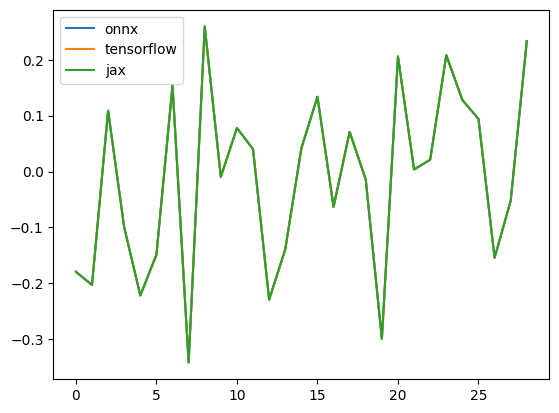

In [19]:
import matplotlib.pyplot as plt
print(onnx_pred.shape)
print(tensorflow_pred.shape)
print(jax_pred.shape)
plt.plot(onnx_pred, label='onnx')
plt.plot(tensorflow_pred, label='tensorflow')
plt.plot(jax_pred, label='jax')
plt.legend()
plt.show()

In [20]:
env_cfg = locomotion.get_default_config(env_name)
env = locomotion.load(env_name, config=env_cfg)
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

Available environments: dict_keys(['BarkourJoystick', 'BerkeleyHumanoidJoystickFlatTerrain', 'BerkeleyHumanoidJoystickRoughTerrain', 'G1Contact', 'G1Stance', 'G1JoystickFlatTerrain', 'G1JoystickRoughTerrain', 'Go1JoystickFlatTerrain', 'Go1JoystickRoughTerrain', 'Go1Getup', 'Go1Handstand', 'Go1Footstand', 'H1InplaceGaitTracking', 'H1JoystickGaitTracking', 'Op3Joystick', 'SpotFlatTerrainJoystick', 'SpotGetup', 'SpotJoystickGaitTracking', 'T1JoystickFlatTerrain', 'T1JoystickRoughTerrain'])


In [21]:
# Test the policy.

# env_cfg = locomotion.get_default_config(env_name)
# env_cfg.init_from_crouch = 0.0
# env = locomotion.load(env_name, config=env_cfg)
# env_cfg = manipulation.get_default_config(env_name)
# env = manipulation.load(env_name, config=env_cfg)
# jit_reset = jax.jit(env.reset)
# jit_step = jax.jit(env.step)

x = 0.8
y = 0.0
yaw = 0.3
command = jp.array([x, y, yaw])
# actions = []

states = [state := jit_reset(jax.random.PRNGKey(555))]
state.info["command"] = command
for _ in range(env_cfg.episode_length):
  onnx_input = {'obs': np.array(state.obs["state"].reshape(1, -1))}
  action = m.run(output_names, onnx_input)[0][0]
  state = jit_step(state, jp.array(action))
  state.info["command"] = command
  states.append(state)
  # actions.append(state.info["motor_targets"])
  # actions.append(action)
  if state.done:
    print("Unexpected termination.")
    break

/home/mohamedash/mujoco_playground/.venv/lib/python3.11/site-packages/jax/_src/interpreters/xla.py:112: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


Unexpected termination.


In [23]:
import mediapy as media
fps = 1.0 / env.dt

frames = env.render(
    states,
    camera="track",
    width=640*2,
    height=480*2,
)
media.show_video(frames, fps=fps, loop=False)

100%|██████████| 54/54 [00:00<00:00, 78.33it/s]
